# New methods of making cuts out of Triplets
A central instrument in applying Tangles is the cut one generates. We have seen that bad cuts result in subpar Tangles performance. 

So far, we have very naively generated the cuts out of Triplets for Tangles by just interpreting a question of the type "b:c?" as a cut and putting all points a that answer yes in one half of the bipartition, and all that answer no as the other half.

As we have seen, this might cause some issues with bias (as in the case of bad gaussian geometry), as well as with noise (we very quickly deteriorate with random imputing). Alas, for real world triplet tasks, this might not be the smartest way to go. 

Real world triplets are often just a small collection of (a, b:c?) answers, meaning the table we receive is very sparse. If we would use our typical cut-preprocessing mechanism, this would require random imputing (or k-NN, which is not desirable in cases such as odd-one-out, see experiment 15, as this produces questionnaires that are degenerate). 

This experiment aims to investigate different methods of processing triplets to cuts, ideally ones, that solve the following problems:

- resistant to noise
- can work with sparse matrices
- good performance on mindset data and euclidean data

## Neighbour Cuts
We assume triplet data of the form (a,b,c), which corresponds to the statement:

a is closer to b than to c.

In Tangles, for the clustering to work, our basic assumption is, that a cut tends to put similar points on each side of the cut. If we look at the above triplet information, we already get similarity information: a is closer to b than to c.

If we treat this as a mini-cut, the triplet information above essentially tells us to put a together with b on one side of the cut, and c on the other. Of course, one triplet information doesn't mean much for the whole clustering, as b and c could just be points from a completely different cluster than a, in which case, the cut could be misleading. Also, we might have a directly following triplet (a,d,b), which tells us to put a and d on one side, and b on the other. The question is then, on what side do we put a and b?

Using these ideas, there are multiple methods we could use to resolve the conflict. We might decide to put b randomly, randomly weighted, by majority vote, generate multiple different cuts or maybe some smarter method. For a first version, we want to explore what we call here majority vote cuts.

### Majority vote cuts
We proceed as follows: Let $X$ be the set of datapoints and $T$ be the set of
available triplets.
Let $x \in X$. We then denote by $$L(x) = \{(x,b,c) \in T \mid b,c\in X \}$$ the set of triplets that have $x$ as a first entry. Analogously, let $M(x)$ the set of triplets out of $T$, where the point $x$ is the second position, and $R(x)$ the set where $x$ is in the third position.

We now produce a corresponding cut $C_a$ as follows:
$$C_a = \{x \in X \mid |M(x) \cap L(a)| > | R(x) \cap L(a) \} \cup {a} $$

In words, all points are in the cut that are closer to $a$ more often than they are not (an alternative would be to decided randomly on a tie). 

If we would imagine a simple mixture of gaussians, this kind of makes sense. If we sample a lot of triplets with $a$ in the first positions, points that are in the same cluster should be closer to $a$ very often (as there are more out-of-cluster points than in-cluster points), while out of cluster points should be closer less often (as they are farther compared to in-cluster points, and to some degree random compared to other out-of-cluster points). 

We will now investigate the performance of this cut finding algorithm on the usual data (mixtures of gaussians and mindset models). 

In [1]:
import sys
sys.path.append("..")
from cblearn.embedding import SOE
import cblearn.datasets as datasets
from questionnaire import Questionnaire, unify_triplet_order
from plotting import AltairPlotter
from sklearn.metrics import normalized_mutual_info_score
from estimators import OrdinalTangles, SoeKmeans
from data_generation import generate_gmm_data_fixed_means
import numpy as np
import altair as alt
from triplets import triplets_to_majority_neighbour_cuts, majority_neighbours_count_matrix
alt.renderers.enable('altair_saver', fmts=["html", "svg"])
seed = 5

As a start, we implement the algorithm itself. We decide to work the the cblearn triplet format, where Triplets are (n_datapoints, 3) ndarrays that are statements of the form

`array[0] is closer to array[1] than array[2]`

Testing with a mixture of gaussians.

In [2]:
data = generate_gmm_data_fixed_means(n=30, means=np.array([[-6,3], [6,3], [-6,-3]]), std=1.0, seed=seed)
triplets, responses = datasets.make_random_triplets(data.xs, result_format="list-boolean", size=30000)
unified_triplets = unify_triplet_order(triplets, responses)
questionnaire = Questionnaire.from_bool_array(triplets, responses)

# tangles
cuts = np.concatenate((triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.3), triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.5)), axis=1)
# cuts = triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.5)
tangles = OrdinalTangles(agreement=13)
y_tangles = tangles.fit_predict(cuts)

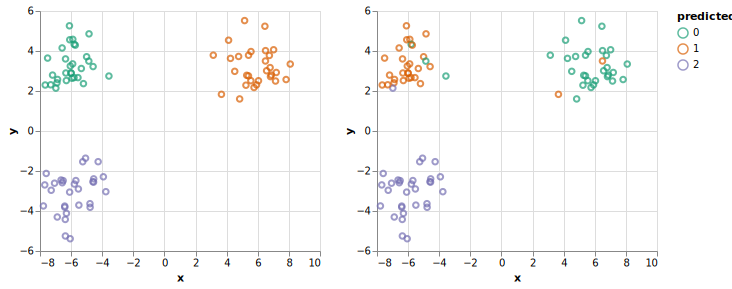

In [3]:
p = AltairPlotter()
p.assignments(data.xs, data.ys).properties(width=280, height=240) | p.assignments(data.xs, y_tangles).properties(width=280, height=240) 

In [4]:
print(f"NMI Tangles: {normalized_mutual_info_score(y_tangles, data.ys)} ({np.unique(y_tangles).size} clusters)")

NMI Tangles: 0.7831706205809403 (3 clusters)


Now testing with clusters of different size. We assume that this will require us to inject cuts of multiple radii. 

In [89]:
data = generate_gmm_data_fixed_means(n=[40, 40, 20], means=np.array([[-6,3], [6,3], [-6,-3]]), std=1.0, seed=seed)
triplets, responses = datasets.make_random_triplets(data.xs, result_format="list-boolean", size=30000)
unified_triplets = unify_triplet_order(triplets, responses)
questionnaire = Questionnaire.from_bool_array(triplets, responses)

# tangles
cuts = np.concatenate((triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.25), triplets_to_majority_neighbour_cuts(unified_triplets, radius=2/3)), axis=1)
# cuts = triplets_to_majority_neighbour_cuts(unified_triplets, radius=2/3)
tangles = OrdinalTangles(agreement=10)
y_tangles = tangles.fit_predict(cuts)
print(f"NMI Tangles: {normalized_mutual_info_score(y_tangles, data.ys)} ({np.unique(y_tangles).size} clusters)")

NMI Tangles: 0.6945868898246136 (3 clusters)


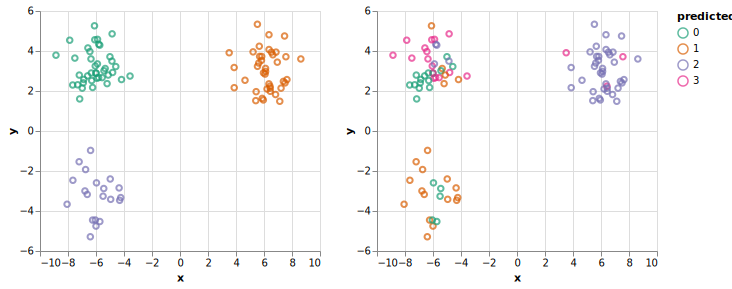

In [69]:
p.assignments(data.xs, data.ys).properties(width=280, height=240) | p.assignments(data.xs, y_tangles).properties(width=280, height=240) 

I tried also testing SOE-kMeans and the other imputation methods on the above set, but that was too many triplets to deal with for the algorithms. This might be a strength for us.

In [7]:
# Tangles with imputations
questionnaire = Questionnaire.from_bool_array(triplets, responses)
q_random = questionnaire.impute("random")
q_knn = questionnaire.impute("10-NN")
y_random = tangles.fit_predict(q_random.values)
y_knn = tangles.fit_predict(q_knn.values)

# soe-kmeans
soe_kmeans = SoeKmeans(2, 3)
y_soe = soe_kmeans.fit_predict(triplets, responses)

Imputing via knn


In [8]:
print(f"NMI Tangles: {normalized_mutual_info_score(y_tangles, data.ys)} ({np.unique(y_tangles).size} clusters)")
print(f"NMI randomly imputed: {normalized_mutual_info_score(y_random, data.ys)}")
print(f"NMI knn imputed: {normalized_mutual_info_score(y_knn, data.ys)}")
print(f"NMI soe-kmeans: {normalized_mutual_info_score(y_soe, data.ys)}")

NMI Tangles: 0.5835858317766122 (2 clusters)
NMI randomly imputed: 0.0
NMI knn imputed: 0.778979417334536
NMI soe-kmeans: 1.0


As we can see, none of the algorithms perform acceptably on this low number of triplets. The requires number of triplets seems a bit high here (we used 50k above to get acceptable performance for majority-neighbour tangles). 

David has said that the number of triplets is O(n*d*log(n)), which amounts to about 1500 in this case. Maybe we are doing something wrong here? Should be investigated.

## Investigating the produced cuts
In the case of our previous cut processing, we had a very good intuition of how our cuts looked like. With this method, we suspect it is something like a "circle" (of course based on the distance metric used). We will survey some of the produced cuts.

In [9]:
def plot_cut(cuts: np.ndarray, i: int) -> alt.Chart:
    """
    Plots cut i. Marks the point the cut is centered around with label 2.
    """
    p = AltairPlotter()
    cut_with_designated_point = cuts[:, i].copy()
    cut_with_designated_point[i] = 2
    return p.assignments(data.xs, cut_with_designated_point).properties(width=170, height=150).interactive()

In [10]:
data = generate_gmm_data_fixed_means(n=30, means=np.array([[-6,3], [6,3], [-6,-3]]), std=1.0, seed=seed)
q = Questionnaire.from_metric(data.xs)
triplets, responses = q.to_bool_array()
unified_triplets = unify_triplet_order(triplets, responses)
questionnaire = Questionnaire.from_bool_array(triplets, responses)

# tangles
cuts_half = triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.5)
cuts_one =  triplets_to_majority_neighbour_cuts(unified_triplets, radius=1)
cuts_two =  triplets_to_majority_neighbour_cuts(unified_triplets, radius=2)

Generating questionnaire...
Generating question set...
Filling out questionnaire...


100%|██████████| 90/90 [00:00<00:00, 503.97it/s]


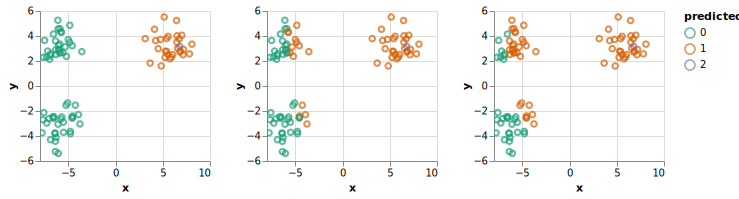

In [11]:
plot_cut(cuts_half, 50) | plot_cut(cuts_one, 50) | plot_cut(cuts_two, 50)

We can repeat the same experiment with a lower amount of triplets. This introduces some form of error/noise, as we can see.

In [12]:
data = generate_gmm_data_fixed_means(n=30, means=np.array([[-6,3], [6,3], [-6,-3]]), std=1.0, seed=seed)
triplets, responses = datasets.make_random_triplets(data.xs, result_format="list-boolean", size=5000)
unified_triplets = unify_triplet_order(triplets, responses)
questionnaire = Questionnaire.from_bool_array(triplets, responses)

# tangles
# cuts_half = triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.5)
cuts_half = triplets_to_majority_neighbour_cuts(unified_triplets, radius=0.5)
cuts_one =  triplets_to_majority_neighbour_cuts(unified_triplets, radius=1)
cuts_two =  triplets_to_majority_neighbour_cuts(unified_triplets, radius=2)

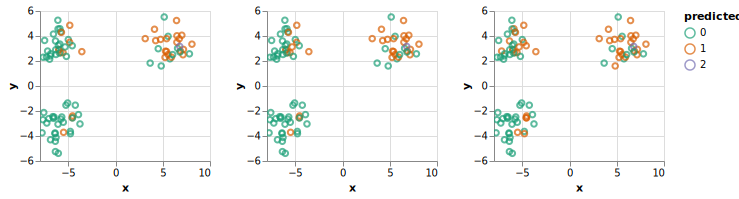

In [13]:
plot_cut(cuts_half, 50) | plot_cut(cuts_one, 50) | plot_cut(cuts_two, 50)

As we can see, we have a lot more noise in the cuts. Since on ties, we put the point not in the cut, we have more points that are left out of the cut. Essentially, we don't have enough triplets to say anything about a lot of them.

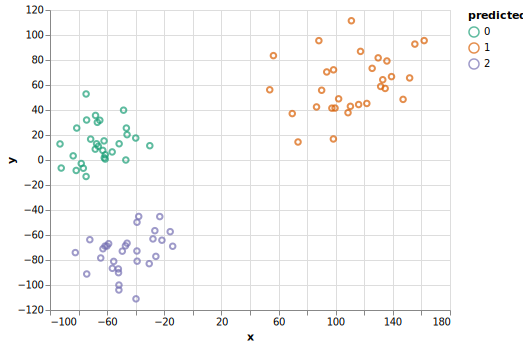

In [14]:
soe = SOE(random_state=5)
embedding = soe.fit_transform(triplets, responses)
p.assignments(embedding, data.ys)